# Clustering with K-Means

Here we'll cluster our funds for the purpose of re-creating a covariance and/or correlation matrix.

In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabasz_score, silhouette_score, davies_bouldin_score


import matplotlib.pyplot as plt

In [2]:
from sklearn.preprocessing import MinMaxScaler

from bokeh.plotting import figure, output_file, show, output_notebook
from bokeh.models import ColorBar, ColumnDataSource, Panel, Tabs
from bokeh.transform import factor_cmap, linear_cmap
from bokeh.palettes import brewer, d3, viridis

In [3]:
def make_plot(data):
    data = data.copy()
    cluster = data['cluster'].unique()
    sc = MinMaxScaler((10, 50))
    data['scaled_value'] = sc.fit_transform(data['netPatrimony'].values.reshape(-1, 1))
    
    tooltips = [
        ('Fund', '@fundName'),
        ('AAFM', '@aafmCategory'),
        ('Cluster', '@cluster'),
        ('AUM', '@netPatrimony'),
        ('AnnRet', '@ann_return'),
        ('AnnStDev', '@ann_stdev'),
        ('Anomaly', '@dist_anomaly')
    ]
    p = figure(plot_width=800, plot_height=800, tooltips=tooltips, title=f'Chilean Mutual Funds', x_axis_label='Component 1',
              y_axis_label='Component 2')
    source = ColumnDataSource(data=data)
    cmap = linear_cmap('cluster', palette=viridis(len(cluster)), low=cluster.min(), high=cluster.max())
    p.circle('x_coord', 'y_coord', source=source, size='scaled_value', color=cmap, alpha=0.7)
    cmap_anomaly = linear_cmap('dist_anomaly', palette=[None, '#ff0000'], low=0, high=1)
    p.cross('x_coord', 'y_coord', source=source, size='scaled_value', color=cmap_anomaly)
    return p

In [4]:
data = pd.read_csv('../data/FundDataWithMonthlyReturnsTSNEandScored.csv')
data.head()

,fundRUN,fundName,fundSeries,aafmCategory,svsCategory,svsCategoryId,currency,fundRUNSeries,userCategory,2015-01-31,...,2021-01-31,x_coord,y_coord,netPatrimony,providedFlow,rescuedFlow,ann_return,ann_stdev,pca_anomaly,dist_anomaly
0,8812-9,A. CHILE CALIFICADO,D,Inversionistas Calificados Accionario Nacional,FM DIRIGIDO A INVERSIONISTAS CALIFICADOS,8.0,P,8812-9D,"Domestic Bond, < 365",0.0,...,0.007059,49.043568,31.558483,2.057013e+08,1.397999e+06,1.624005e+06,0.054833,18.275449,0,0
1,8289-9,ACCIONES CHILE,APV,Accionario Nacional Large CAP,FM DE INVERSION EN INSTRUMENTOS DE CAPITALIZACION,5.0,P,8289-9APV,Domestic Equity,0.0,...,0.021519,48.599960,29.826206,9.093564e+07,5.398776e+04,2.750340e+04,-2.699522,18.133874,0,0
2,8076-4,ACCIONES CHILENAS,APV,Accionario Nacional Large CAP,FM DE INVERSION EN INSTRUMENTOS DE CAPITALIZACION,5.0,P,8076-4APV,Domestic Equity,0.0,...,0.024364,46.495964,24.676537,5.264871e+09,1.849870e+06,3.550476e+06,-0.228134,18.098522,0,0
3,9254-1,ACCIONES EUROPA,ALTO,Accionario Europa Desarrollado,FM DE INVERSION EN INSTRUMENTOS DE CAPITALIZACION,5.0,P,9254-1ALTO,International Equity,0.0,...,0.019622,-46.026010,3.815157,1.038922e+09,6.401805e+06,1.216734e+06,0.444373,20.991343,0,0
4,8247-3,ACCIONES LATAM,A,Accionario America Latina,FM DE INVERSION EN INSTRUMENTOS DE CAPITALIZACION,5.0,P,8247-3A,International Equity,0.0,...,-0.017005,-2.541078,-44.528522,2.430189e+09,1.271666e+07,8.701922e+06,0.701076,23.831971,0,0


In [5]:
print(f"Number of current categories: {data['aafmCategory'].nunique()}")

Number of current categories: 31


## Selecting subset of columns

We'll use the annualized returns and standard deviation, along with the TSNE components, to cluster the funds.  We're not including the monthly returns as that information is already encoded in the TSNE components.

In [6]:
# cols = data.columns[9:-10]  # only return data
cols = data.columns[-4:-2] # only use annual return and stdev
cols = cols.append(data.columns[-9:-7])  # adds tSNE coordinates
# cols = cols.append(data.columns[-4:-2])  # adds annual return and stdev

df = data[cols]

## Tuning the number of clusters

We'll tune the number of clusters using several methods.  We don't presume to know the "ground truth" cluster membership, so we'll use metrics that don't require that.

In [7]:
dist = []
score = {'calinski_harabasz':[], 'silhouette':[], 'davies_bouldin': []}
n_clusters = list(range(2, 30))
for k in n_clusters:
    pl = Pipeline(
        steps=[
            ('scaler', StandardScaler()),
            ('cluster', KMeans(n_clusters=k, random_state=897))
        ]
    )
    pl.fit(df)
    dist.append(pl.named_steps['cluster'].inertia_)
    score['calinski_harabasz'].append(calinski_harabasz_score(df, pl.named_steps['cluster'].labels_))
    score['silhouette'].append(silhouette_score(df, pl.named_steps['cluster'].labels_))
    score['davies_bouldin'].append(davies_bouldin_score(df, pl.named_steps['cluster'].labels_))

The **elbow** method is rather subjective.  The idea is to select the number of clusters that balances the minimization of within-cluster distances (y-axis) and the improvement with the marginal cluster.  It *looks* like this could be somewhere between 7-10 clusters.

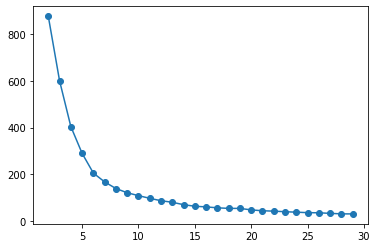

In [8]:
plt.plot(n_clusters, dist, 'o-')
plt.show()

These methods provide a more objective viewpoint:

### Calinski-Harabasz

If the ground truth labels are not known, the Calinski-Harabasz index - also known as the Variance Ratio Criterion - can be used to evaluate the model, where a higher Calinski-Harabasz score relates to a model with better defined clusters.

The index is the ratio of the sum of between-clusters dispersion and of within-cluster dispersion for all clusters (where dispersion is defined as the sum of distances squared):

### Silhouette

A higher Silhouette Coefficient score relates to a model with better defined clusters.

### Davies-Bouldin

This index signifies the average ‘similarity’ between clusters, where the similarity is a measure that compares the distance between clusters with the size of the clusters themselves.

Zero is the lowest possible score. Values closer to zero indicate a better partition.

**Higher is better**
- Calinski-Harabasz
- Silhouette

**Lower is better**
- Davies-Bouldin

### Results

The Calinski-Harabasz score is inconclusive-- the score exhibits multiple, increasing peaks.  The Silhouette and Davies-Bouldin scores indicate that 10 clusters may be appropriate.

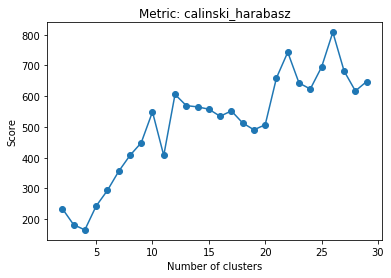

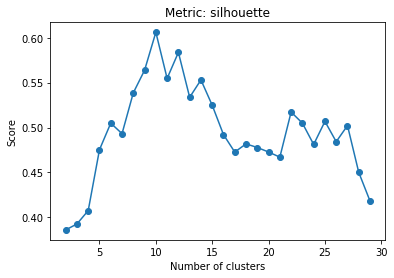

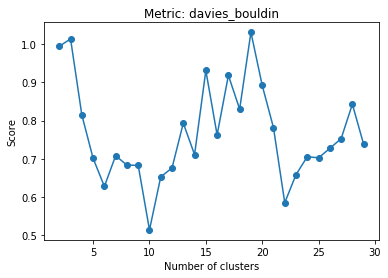

In [9]:
for metric in score:
    plt.plot(n_clusters, score[metric], 'o-')
    plt.title(f'Metric: {metric}')
    plt.xlabel('Number of clusters')
    plt.ylabel('Score')
    plt.show()

## Run K-means pipeline and plot results

We'll use our original TSNE mapping, but replace the `aafmCategory` factor with our new cluster labels.

In [10]:
pl = Pipeline(
        steps=[
            ('scaler', StandardScaler()),
            ('cluster', KMeans(n_clusters=10, n_init=20, random_state=7))
        ]
    )
pl.fit(df)
labels = pl.named_steps['cluster'].labels_
n_clusters = len(np.unique(labels))
data['cluster'] = labels

In [11]:
data.to_csv('../data/FundDataWithMonthlyReturnsTSNEScoredScaledClustered.csv', index=False)

In [12]:
output_notebook()
show(make_plot(data))

Loading BokehJS ...

### A quick look at the mean and variance of annual returns/standard devations by cluster:

In [13]:
data.groupby('cluster')[['ann_return', 'ann_stdev']].mean()

,ann_return,ann_stdev
cluster,,
0,4.049751,3.480932
1,8.171037,16.314688
2,2.873372,9.324288
3,-3.220731,19.306828
4,-46.742486,41.130730
5,1.992375,0.646060
6,0.889074,25.998534
7,3.563876,6.079183
8,7.665176,14.659476


In [14]:
data.groupby('cluster')[['ann_return', 'ann_stdev']].var()

,ann_return,ann_stdev
cluster,,
0,1.271838,1.949715
1,12.337890,5.511523
2,8.324328,10.934828
3,13.401945,4.261162
4,252.032111,9.237230
5,0.866047,0.490865
6,9.534459,13.658156
7,3.418851,2.094771
8,6.267180,4.335282


## Create correlation matrix for AAFM categories

In [15]:
aafm_corr = data.groupby('aafmCategory').mean()
aafm_corr = aafm_corr.loc[:, '2015-02-28':'2021-01-31'].T.corr()
aafm_corr.to_csv('../data/aafmCategoryCorrelationMatrix.csv')
aafm_corr

aafmCategory,Accionario America Latina,Accionario Asia Emergente,Accionario Asia Pacifico,Accionario Brasil,Accionario Desarrollado,Accionario EEUU,Accionario Emergente,Accionario Europa Desarrollado,Accionario Europa Emergente,Accionario Nacional Large CAP,...,Fondos de Deuda < 90 Dias Nacional,"Fondos de Deuda > 365 Dias Internacional, Mercados Emergentes","Fondos de Deuda > 365 Dias Internacional, Mercados Internacionales","Fondos de Deuda > 365 Dias Nacional, Inversion UF > 3 años y =<5","Fondos de Deuda > 365 Dias Nacional, Inversion en UF > 5 años","Fondos de Deuda > 365 Dias Nacional, Inversión en Pesos","Fondos de Deuda > 365 Dias Nacional, Inversión en UF < 3 años",Fondos de Deuda > 365 Dias Orig. Flex,Inversionistas Calificados Accionario Nacional,Inversionistas Calificados Títulos de Deuda
aafmCategory,,,,,,,,,,,,,,,,,,,,,
Accionario America Latina,1.000000,0.368065,0.312473,0.938067,0.390518,0.348762,0.654604,0.508788,0.759145,0.659009,...,0.056525,0.807846,0.406089,0.291770,0.293069,0.327669,0.229303,0.377481,0.617614,0.715189
Accionario Asia Emergente,0.368065,1.000000,0.318340,0.257627,0.781956,0.693076,0.933632,0.724459,0.534131,0.331085,...,0.067178,0.447838,0.568724,0.010767,-0.010411,0.038817,0.016775,0.082579,0.300388,0.338769
Accionario Asia Pacifico,0.312473,0.318340,1.000000,0.248745,0.456511,0.452031,0.384232,0.412857,0.430094,0.312175,...,0.086524,0.204852,0.190710,0.509591,0.257984,0.235227,0.275062,0.300073,0.294234,0.255855
Accionario Brasil,0.938067,0.257627,0.248745,1.000000,0.269530,0.243628,0.539407,0.343732,0.671020,0.522647,...,0.059277,0.738378,0.359420,0.226552,0.236232,0.294275,0.159789,0.299258,0.486086,0.615642
Accionario Desarrollado,0.390518,0.781956,0.456511,0.269530,1.000000,0.947335,0.768535,0.918870,0.709683,0.267813,...,0.221762,0.448310,0.754664,0.170780,0.119556,0.098228,0.180784,0.191195,0.245928,0.393577
Accionario EEUU,0.348762,0.693076,0.452031,0.243628,0.947335,1.000000,0.689352,0.836279,0.650117,0.235386,...,0.149228,0.390667,0.680612,0.221195,0.167233,0.160698,0.245208,0.228158,0.223908,0.404277
Accionario Emergente,0.654604,0.933632,0.384232,0.539407,0.768535,0.689352,1.000000,0.766279,0.720343,0.518464,...,0.065995,0.662588,0.576386,0.149126,0.127115,0.183084,0.136703,0.233690,0.481169,0.538196
Accionario Europa Desarrollado,0.508788,0.724459,0.412857,0.343732,0.918870,0.836279,0.766279,1.000000,0.759018,0.381642,...,0.264614,0.543944,0.697554,0.191695,0.159301,0.134605,0.187861,0.234649,0.360058,0.480085
Accionario Europa Emergente,0.759145,0.534131,0.430094,0.671020,0.709683,0.650117,0.720343,0.759018,1.000000,0.508887,...,0.179453,0.677516,0.585089,0.329144,0.284159,0.325170,0.314190,0.379005,0.487333,0.582462


## Create correlation matrix for clusters

In [16]:
cluster_corr = data.groupby('cluster').mean()
cluster_corr = cluster_corr.loc[:, '2015-02-28':'2021-01-31'].T.corr()
cluster_corr.to_csv('../data/clusterCorrelationMatrix.csv')
cluster_corr

cluster,0,1,2,3,4,5,6,7,8,9
cluster,,,,,,,,,,
0,1.000000,0.151721,0.491206,0.421751,0.373080,0.568195,0.316090,0.597327,0.099108,0.333026
1,0.151721,1.000000,0.403065,0.227443,0.347442,0.052098,0.323396,0.806227,0.779959,0.882420
2,0.491206,0.403065,1.000000,0.512900,0.184342,0.157908,0.796860,0.705122,0.518169,0.690643
3,0.421751,0.227443,0.512900,1.000000,0.347592,0.130450,0.597172,0.602338,0.377299,0.583032
4,0.373080,0.347442,0.184342,0.347592,1.000000,0.173437,0.297806,0.423065,0.242917,0.429301
5,0.568195,0.052098,0.157908,0.130450,0.173437,1.000000,0.085815,0.268028,-0.102282,0.090488
6,0.316090,0.323396,0.796860,0.597172,0.297806,0.085815,1.000000,0.587642,0.435056,0.636861
7,0.597327,0.806227,0.705122,0.602338,0.423065,0.268028,0.587642,1.000000,0.738891,0.928149
8,0.099108,0.779959,0.518169,0.377299,0.242917,-0.102282,0.435056,0.738891,1.000000,0.839293


## Efficient Frontier Portfolio
First we will start with the aafm categories funds.

In [40]:
data_cluster=data.loc[:,'2015-01-31':'2021-01-31']
data_cluster['cluster']=data['cluster']
data_cluster=data_cluster.groupby('cluster').mean().T
data_cluster=data_cluster[1:]
data_cluster.head()

cluster,0,1,2,3,4,5,6,7,8,9
2015-02-28,0.006460,0.028066,0.011483,0.037932,0.024591,0.002859,0.013008,0.008439,-0.004412,0.019851
2015-03-31,0.004465,0.008537,-0.002216,-0.015217,-0.000701,0.002368,-0.065749,0.003769,0.009325,-0.002411
2015-04-30,-0.003375,-0.009388,0.020096,0.018675,0.001189,0.001163,0.061882,-0.002147,0.038131,0.011853
2015-05-31,0.003821,0.017410,0.001024,-0.010036,0.006226,0.002276,-0.054477,0.003327,-0.011864,0.001439
2015-06-30,0.004834,0.002427,-0.011714,-0.036378,-0.003090,0.001758,0.029973,-0.000659,-0.006445,-0.005427


In [97]:
cluster_funds=data['userCategory'].unique()

In [63]:
#create 6000 portfolios so we can have a sample of almost all portfolio condition due to volatility and returns.
np.random.seed(42)
num_ports = 6000
all_weights = np.zeros((num_ports, len(data_cluster.columns)))
ret_arr = np.zeros(num_ports)
vol_arr = np.zeros(num_ports)
sharpe_arr = np.zeros(num_ports)

for x in range(num_ports):
    # Weights
    weights = np.array(np.random.random(10))
    weights = weights/np.sum(weights)
    
    # Save weights
    all_weights[x,:] = weights
    
    # Expected return
    ret_arr[x] = np.sum( (data_cluster.mean() * weights * 12))
    
    # Expected volatility
    vol_arr[x] = np.sqrt(np.dot(weights.T, np.dot(data_cluster.cov()*12, weights)))
    
    # Sharpe Ratio
    sharpe_arr[x] = ret_arr[x]/vol_arr[x]

In [64]:
#the optimal portfolio is located in this point.
print('Max sharpe ratio in the array: {}'.format(sharpe_arr.max()))
print('Location in the array: {}'.format(sharpe_arr.argmax()))

Max sharpe ratio in the array: 0.7595716197811605
Location in the array: 1901


In [66]:
#the weight of the optimal portfolio is:
print(all_weights[1901,:]*100)

[25.07334659 23.94227984 12.54861539  2.57000829  0.40159012  9.56528158
  0.30613054  7.63719011 13.92519844  4.0303591 ]


In [67]:
max_sr_ret=ret_arr[sharpe_arr.argmax()]
max_sr_vol=vol_arr[sharpe_arr.argmax()]

## First look of what the portfolio samples would look like

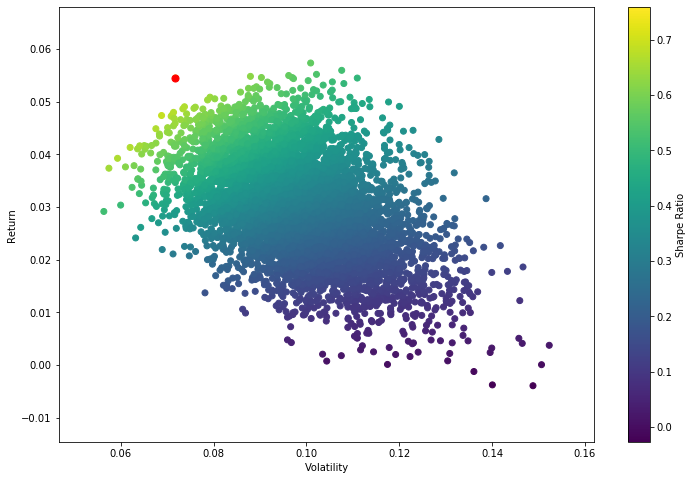

In [68]:
plt.figure(figsize=(12,8))
plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.scatter(max_sr_vol, max_sr_ret,c='red', s=50) # red dot
pclt.show()

In [100]:
#pd.DataFrame(vol_arr,ret_arr)
efficient_frontier_cluster=pd.DataFrame(all_weights*100,columns=cluster_funds)
efficient_frontier_cluster['x_coord_vol']=vol_arr
efficient_frontier_cluster['y_coord_ret']=ret_arr
efficient_frontier_cluster.head()

,"Domestic Bond, < 365",Domestic Equity,International Equity,"Balanced, Aggressive","Balanced, Moderate","Balanced, Conservative","Domestic Bond, > 365",Emerging Equity,"International Bond, > 365","International Bond, < 365",x_coord_vol,y_coord_ret
0,7.200801,18.278161,14.073106,11.509637,2.999570,2.999106,1.116699,16.652855,11.556865,13.613201,0.089412,0.044501
1,0.520773,24.538041,21.060217,5.372031,4.600045,4.640006,7.697116,13.275971,10.927907,7.367894,0.098845,0.047058
2,15.281528,3.483974,7.296552,9.150188,11.390722,19.610414,4.987017,12.843427,14.796040,1.160137,0.079321,0.024918
3,11.929704,3.348399,1.277348,18.632243,18.961076,15.873628,5.981372,1.917882,13.435547,8.642800,0.110369,0.011932
4,3.016589,12.239978,0.850029,22.476941,6.396626,16.376487,7.704997,12.855247,13.513800,4.569305,0.096981,0.031127


In [101]:
efficient_frontier_cluster.to_csv('../data/efficient_frontier_kmeans_cluster_withweights.csv')

We continue with the aafm categories.

In [41]:
data_aafm=data.loc[:,'2015-01-31':'2021-01-31']
data_aafm['aafmCategory']=data['aafmCategory']
data_aafm=data_aafm.groupby('aafmCategory').mean().T
data_aafm=data_aafm[1:]
data_aafm.head()

aafmCategory,Accionario America Latina,Accionario Asia Emergente,Accionario Asia Pacifico,Accionario Brasil,Accionario Desarrollado,Accionario EEUU,Accionario Emergente,Accionario Europa Desarrollado,Accionario Europa Emergente,Accionario Nacional Large CAP,...,Fondos de Deuda < 90 Dias Nacional,"Fondos de Deuda > 365 Dias Internacional, Mercados Emergentes","Fondos de Deuda > 365 Dias Internacional, Mercados Internacionales","Fondos de Deuda > 365 Dias Nacional, Inversion UF > 3 años y =<5","Fondos de Deuda > 365 Dias Nacional, Inversion en UF > 5 años","Fondos de Deuda > 365 Dias Nacional, Inversión en Pesos","Fondos de Deuda > 365 Dias Nacional, Inversión en UF < 3 años",Fondos de Deuda > 365 Dias Orig. Flex,Inversionistas Calificados Accionario Nacional,Inversionistas Calificados Títulos de Deuda
2015-02-28,0.018239,-0.007164,0.026657,0.005819,0.028310,0.034027,0.002256,0.037605,0.039818,0.035919,...,0.002411,0.006992,-0.007591,0.009520,0.008691,0.001830,0.007933,0.005793,0.043719,0.0
2015-03-31,-0.052730,0.011905,0.009811,-0.089508,0.001521,-0.002829,-0.003580,0.013985,-0.023105,-0.015522,...,0.002269,-0.002451,0.003811,0.006403,0.007382,0.000668,0.005933,0.004325,-0.011888,0.0
2015-04-30,0.051737,0.029131,0.002823,0.073876,-0.005492,-0.016480,0.035318,-0.012843,0.081792,0.022690,...,0.001872,0.019257,-0.012289,-0.006371,-0.008377,0.001641,-0.003525,-0.002823,0.019223,0.0
2015-05-31,-0.042291,-0.009808,0.007896,-0.075085,0.012067,0.017419,-0.020220,0.017595,-0.029704,-0.008358,...,0.001764,0.002855,0.000312,0.004804,0.004340,0.001824,0.005050,0.004128,-0.010798,0.0
2015-06-30,0.017162,-0.006494,0.002663,0.058787,-0.000116,0.006180,-0.007906,-0.011900,-0.017682,-0.038001,...,0.000498,-0.011466,0.006912,0.005437,0.004612,0.004684,0.005896,0.004870,-0.041493,0.0


In [112]:
aafm_funds=data_aafm.columns

In [103]:
#create 6000 portfolios so we can have a sample of almost all portfolio condition due to volatility and returns.
np.random.seed(42)
num_ports = 6000
all_weights = np.zeros((num_ports, len(data_aafm.columns)))
ret_arr = np.zeros(num_ports)
vol_arr = np.zeros(num_ports)
sharpe_arr = np.zeros(num_ports)

for x in range(num_ports):
    # Weights
    weights = np.array(np.random.random(31))
    weights = weights/np.sum(weights)
    
    # Save weights
    all_weights[x,:] = weights
    
    # Expected return
    ret_arr[x] = np.sum( (data_aafm.mean() * weights * 12))
    
    # Expected volatility
    vol_arr[x] = np.sqrt(np.dot(weights.T, np.dot(data_aafm.cov()*12, weights)))
    
    # Sharpe Ratio
    sharpe_arr[x] = ret_arr[x]/vol_arr[x]

In [104]:
#the optimal portfolio is located in this point.
print('Max sharpe ratio in the array: {}'.format(sharpe_arr.max()))
print('Location in the array: {}'.format(sharpe_arr.argmax()))

Max sharpe ratio in the array: 0.6814865771958846
Location in the array: 2738


In [105]:
#the weight of the optimal portfolio is:
print(all_weights[2738,:]*100)

[2.16434254 3.80924549 0.9618146  1.13745997 2.62600107 3.61789488
 5.18160031 3.3737793  0.18014507 2.00168607 0.18301067 6.78121815
 0.21449431 0.36634492 2.20348541 4.67127651 2.64437635 0.45481278
 6.17773619 5.17282072 2.92816549 5.00059403 2.02848805 3.89957947
 6.50468197 0.79548493 6.2563563  5.82533542 7.01140375 3.79548334
 2.03088193]


In [106]:
max_sr_ret=ret_arr[sharpe_arr.argmax()]
max_sr_vol=vol_arr[sharpe_arr.argmax()]

## First look of what the portfolio samples would look like

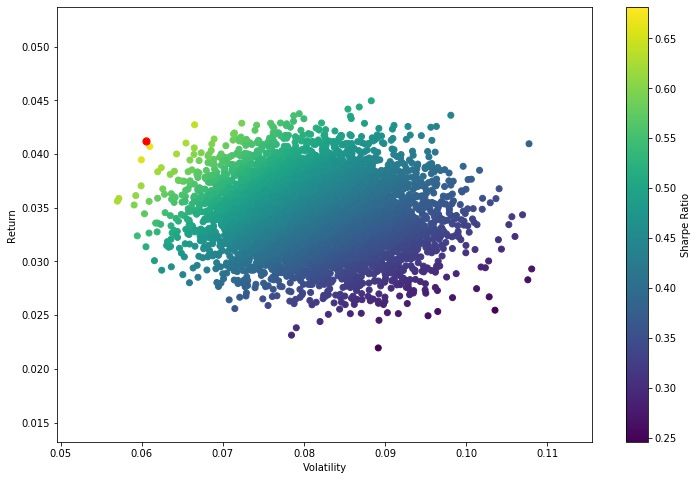

In [107]:
plt.figure(figsize=(12,8))
plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.scatter(max_sr_vol, max_sr_ret,c='red', s=50) # red dot
plt.show()

In [114]:
efficient_frontier_aafm=pd.DataFrame(all_weights*100,columns=aafm_funds)
efficient_frontier_aafm['x_coord_vol']=vol_arr
efficient_frontier_aafm['y_coord_ret']=ret_arr
efficient_frontier_aafm.head()

aafmCategory,Accionario America Latina,Accionario Asia Emergente,Accionario Asia Pacifico,Accionario Brasil,Accionario Desarrollado,Accionario EEUU,Accionario Emergente,Accionario Europa Desarrollado,Accionario Europa Emergente,Accionario Nacional Large CAP,...,"Fondos de Deuda > 365 Dias Internacional, Mercados Internacionales","Fondos de Deuda > 365 Dias Nacional, Inversion UF > 3 años y =<5","Fondos de Deuda > 365 Dias Nacional, Inversion en UF > 5 años","Fondos de Deuda > 365 Dias Nacional, Inversión en Pesos","Fondos de Deuda > 365 Dias Nacional, Inversión en UF < 3 años",Fondos de Deuda > 365 Dias Orig. Flex,Inversionistas Calificados Accionario Nacional,Inversionistas Calificados Títulos de Deuda,x_coord_vol,y_coord_ret
0,2.720868,6.906519,5.317612,4.348989,1.133406,1.133231,0.421952,6.292387,4.366835,5.143834,...,2.661457,3.313147,5.703956,1.450542,3.735686,4.303630,0.337442,4.413545,0.088201,0.034593
1,1.141041,0.435285,6.349350,6.461407,5.409291,2.038285,0.653561,4.578460,2.945226,0.816604,...,4.000774,6.168607,0.592137,1.311395,0.302633,2.176908,2.600786,1.815698,0.086637,0.029327
2,5.381979,2.316824,1.824442,3.524372,0.915189,5.209620,0.484146,6.409032,5.015105,1.290498,...,2.111803,4.738202,4.140420,5.761729,3.066654,0.776668,4.631948,4.940683,0.085535,0.036903
3,3.674159,5.046803,3.232419,3.421844,2.798712,0.166395,0.706265,0.205738,4.165986,2.057796,...,5.260892,1.221300,5.842752,3.530571,5.285558,5.865874,2.081672,0.720407,0.075010,0.034249
4,1.592160,2.983409,5.713950,6.012326,0.048562,3.567643,2.915676,1.551455,0.837277,2.358290,...,3.511285,0.359586,1.946385,6.344367,1.673374,1.012111,3.418898,6.884909,0.090297,0.030318


In [115]:
efficient_frontier_aafm.to_csv('../data/efficient_frontier_kmeans_aafmcat_withweights.csv')